# Визуально о математике, стоящей за некоторыми алгоритмами

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## 1. Градиентный спуск

Во многих алгоритмах градиентный спуск может применяться для оптимизации. Мы рассмотрим, что происходит при минимизации ошибки градиентных спуском.

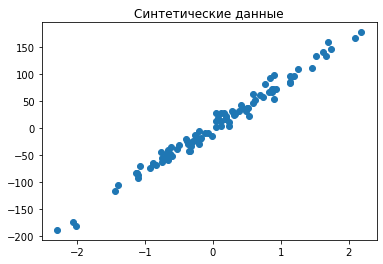

In [2]:
from sklearn.datasets import make_regression
X, y = make_regression(n_samples=100, n_features=1, noise=10, random_state=1)
X = X.flatten()
plt.title('Синтетические данные')
plt.scatter(X, y);

Воспользуемся кодом из второго дня, и немного его модифицируем для сохранения истории.

In [3]:
def update(x, y, k, b, alpha):
    number = len(y)
    change_k = -2 * sum([
        x[index] * (y[index] - k * x[index] - b) for index in range(number)
    ])
    change_b = -2 * sum([
        x[index] * k - y[index] - b for index in range(number)
    ])
    new_k = k - alpha * change_k / number 
    new_b = b - alpha * change_b / number     
    return new_k, new_b

def train_linear(x, y, alpha=0.1, epochs=50):
    k, b = np.random.uniform(-1, 1), np.random.uniform(-1, 1)
    history = []    
    for epoch in range(epochs):
        k, b = update(x, y, k, b, alpha)
        error = np.mean(np.abs(y - k*x - b))
        history.append((k, b, error))
    return k, b, history

Сперва посмотрим как с ростом количества эпох наша прямая всё ближе подходит к данным.

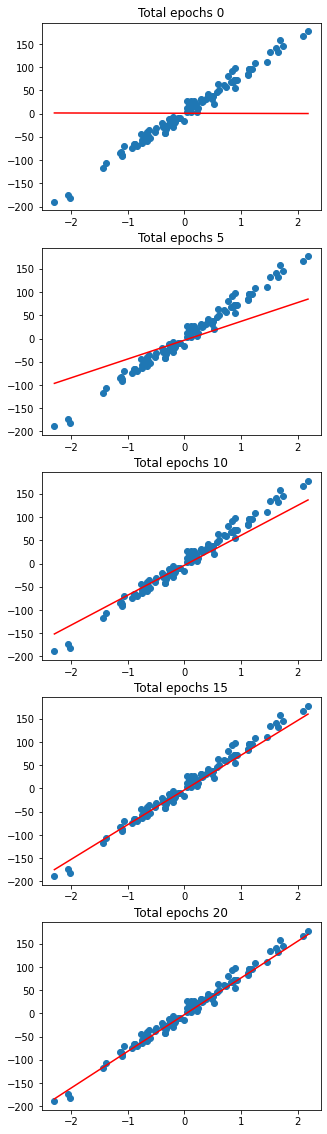

In [4]:
plt.subplots(5, figsize=(5, 20))

space = np.linspace(X.min(), X.max())
for index in range(0, 21, 5):
    k, b, _ = train_linear(X, y, epochs=index - 1)
    plt.subplot(5, 1, index // 5 + 1)
    plt.title("Total epochs %d" % index)
    plt.scatter(X, y);
    plt.plot(space, space * k + b, c='red');

Посмотрим на "траекторию" градиентного спуска, где по осям - наши два коэффициента линейной модели, а по вертикали - ошибка.

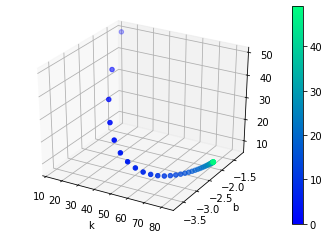

In [5]:
from mpl_toolkits.mplot3d import Axes3D
axes = plt.subplot(projection='3d')

_, _, history = train_linear(X, y)
history = np.asarray(history).reshape(-1, 3)
plotted = axes.scatter(
    history[:, 0],
    history[:, 1],
    history[:, 2],
    c=np.arange(len(history)),
    cmap='winter'
);
plt.colorbar(plotted);
axes.set_xlabel('k');
axes.set_ylabel('b');

Наконец, отобразим тот же путь на поверхности ошибки - которая соответствует множеству пар `k` и `b`.

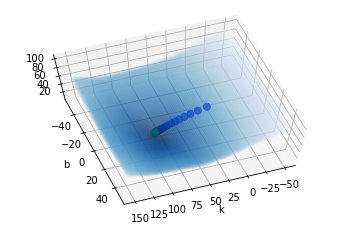

In [6]:
meshgrid = {"x": [], "y": [], "z": []}
for k in np.linspace(-50, 150, 100):
    for b in np.linspace(-50, 50, 100):
        meshgrid['x'] += [k]
        meshgrid['y'] += [b]
        meshgrid['z'] += [np.mean(np.abs(y - k*X - b))]

axes = plt.subplot(projection='3d')
axes.view_init(azim=70, elev=70)
plotted = axes.scatter(
    meshgrid['x'],
    meshgrid['y'],
    meshgrid['z'],
    c=meshgrid['z'],
    cmap='Blues_r',
    alpha=0.075
);
axes.scatter(
    history[:, 0],
    history[:, 1],
    history[:, 2],
    c=np.arange(len(history)),
    cmap='winter',
    s=50
);
axes.set_xlabel('k');
axes.set_ylabel('b');

На рассмотренных отрезках `k` и `b` - у нас один оптимум, и он есть искомый минимум. Градиентным спуском алгоритм как раз к нему и приближается (сначала быстро, потом медленнее).

Практически аналогичным образом поступают оптимизаторы (`rmsprop`, `adam`) по весам нейронных сетей - только там параметров не два, а тысячи и миллионы, локальных оптимумов (глобальный всегда один) может быть не один - а большое множество, и те кривые метрик которые мы видим при обучении нейросети - это как раз один из вариантов отображения пути градиентного спуска. 

Оптимизаторы отличаются тем, как они меняют шаг, как они "ускоряются в протяженных оврагах" и другими деталями, которые позволяют обучать сети эффективнее. Тем не менее в целом принцип - тот же.

## 2. Вычисления на графах

Вопрос, откуда берется производная ошибки по весам для нейросетей? Она вычисляется с помощью графа вычислений. 

В основе лежит формула дифференцирования сложной функции:
$$f'(g(x)) = f'(u) = f'(u) \cdot u'(x)$$

Теперь представим граф вычислений для функции `f(x, y) = x + x * y`.

![graph_maths](media/graph_calculations.svg)

В таком случае, в каждом узле надо взять производную и подсчитать (перемножением по формуле выше) саму производную. Например.

Пусть $$a(x,y) = x \cdot y, b(x, y) = x, f(x, y) = a(x, y) + b(x, y)$$

Тогда для получения частной производной по `x`:
$$\frac {\partial f} {\partial x} = \frac {\partial f} {\partial a} \cdot \frac {\partial a} {\partial x} + \frac {\partial f} {\partial b} \cdot \frac {\partial b} {\partial x} = 1 \cdot y + 1 = y + 1$$

Аналогично считается и производная по `y`:
$$\frac {\partial f} {\partial y} = \frac {\partial f} {\partial a} \cdot \frac {\partial a} {\partial y} + \frac {\partial f} {\partial b} \cdot \frac {\partial b} {\partial y} = 1 \cdot x + 0 = x$$

После получения градиентов можно уже использовать градиентный спуск.

Рассмотрим пример на `tensorflow`. В качестве данных выберем несложную однопараметрическую функцию.

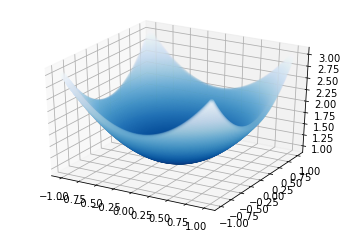

In [7]:
def function(x, y, k=1):
    return x**2 + y**2 + k**2

space = np.linspace(-1, 1, 200)
data = np.array([
    [
        x, y, function(x, y)
    ] for x in space for y in space
]).reshape(-1, 3)

axes = plt.subplot(projection='3d')
plotted = axes.scatter(
    data[:, 0],
    data[:, 1],
    data[:, 2],
    c=data[:, 2],
    cmap='Blues_r',
    alpha=0.1
);

Далее устроим градиентный спуск для этого параметра `k`. 

In [8]:
import tensorflow as tf

class ParameterFinder:
    def __init__(self, initial):
        self.k = tf.Variable(initial)

    def predict(self, X, Y):
        return X**2 + Y**2 + self.k ** 2
    
    def mse(self, true, predicted):
        return tf.reduce_mean(tf.square(true - predicted))
        
    def update(self, X, Y, Z, alpha):  
        with tf.GradientTape(persistent=True) as tape:
            loss = self.mse(Z, self.predict(X, Y))
       
        dk = tape.gradient(loss, self.k)
        self.k.assign_sub(alpha * dk)
        
        return loss
        
    def train(self, X, Y, Z, alpha=0.01, epochs=10, printable=True):
        for epoch in range(epochs):
            loss = self.update(X, Y, Z, alpha)
        if printable:
            print("Parameter %.3f" % self.k)
            print('loss %.3f' % loss)

In [9]:
ParameterFinder(initial=4.0).train(data[:, 0], data[:, 1], data[:, 2], epochs=10)

Parameter 1.175
loss 0.185


In [10]:
ParameterFinder(initial=4.0).train(data[:, 0], data[:, 1], data[:, 2], epochs=100)

Parameter 1.000
loss 0.000


## 3. Немного о решающих деревьях

Деревья "плохи" тем, что их разделяющие границы - осепараллельны. Пример.

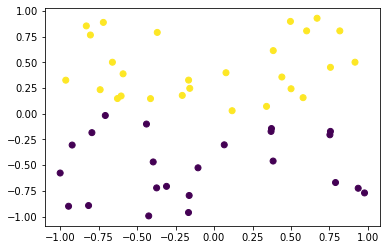

In [11]:
from sklearn.tree import DecisionTreeClassifier

np.random.seed(1)

data = np.column_stack([
    np.random.uniform(-1, 1, size=50),
    np.random.uniform(-1, 1, size=50)
])

classes = data[:, 1] > 0

plt.scatter(data[:, 0], data[:, 1], c=classes);

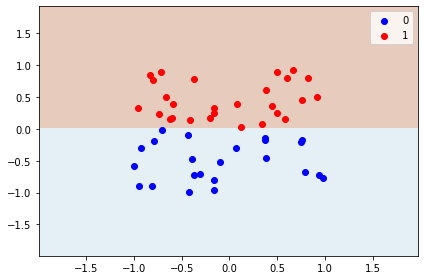

In [12]:
def plot_decisions(x, y, targets, classifier, labels=None):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
    z = z.reshape(xx.shape)
    c = plt.contourf(xx, yy, z, cmap='Paired', alpha=0.3)
    
    for index in range(len(np.unique(targets))):
        indices = np.where(targets == index)
        plt.scatter(x[indices], y[indices], color=[
            'b', 'r', 'y'
        ][index], label=labels[index] if labels is not None else index)

    plt.legend()
    plt.tight_layout()
    plt.show()

classifier = DecisionTreeClassifier(max_depth=1, random_state=1).fit(data, classes)
plot_decisions(data[:, 0], data[:, 1], classes, classifier)

Это было ожидаемо, и решающее дерево по определению с такой простой задачей справилось. Что если мы повернем данные?

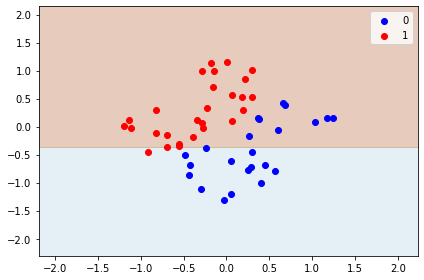

In [13]:
angle = np.deg2rad(45)
affine = np.array([
    [np.cos(angle), -np.sin(angle)],
    [np.sin(angle), +np.cos(angle)]
])
warped = np.array([
    [
        np.dot(affine[0], point),
        np.dot(affine[1], point)
    ] for point in data
]).reshape(-1, 2)

classifier = DecisionTreeClassifier(max_depth=1, random_state=1).fit(warped, classes)
plot_decisions(warped[:, 0], warped[:, 1], classes, classifier)

Граница уехала вниз, но теперь очевидно, большая ошибка. Что можно сделать? Давайте развернём их через `PCA`.

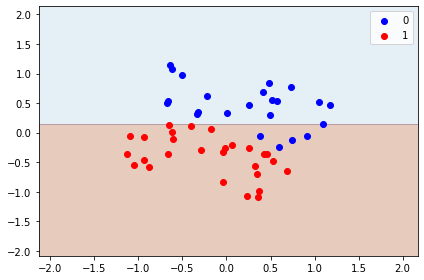

In [14]:
from sklearn.decomposition import PCA

reduced = PCA(n_components=2, random_state=1).fit_transform(warped)
classifier = DecisionTreeClassifier(max_depth=1, random_state=1).fit(reduced, classes)
plot_decisions(reduced[:, 0], reduced[:, 1], classes, classifier)

Лучше, как бы... но нет. Давайте использовать `UMAP`.

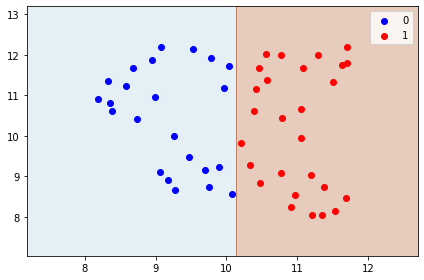

In [15]:
from umap import UMAP

mapped = UMAP(n_components=2, n_neighbors=30, random_state=1).fit_transform(warped)
classifier = DecisionTreeClassifier(max_depth=1, random_state=1).fit(mapped, classes)
plot_decisions(mapped[:, 0], mapped[:, 1], classes, classifier)

## 4. Топологический анализ
Или немного о том, как устроен **UMAP**.

Начинается всё слегка издалека: из топологии, раздела математики, который отвечает за различение объектов по связности - то есть сферу от бублика, или же восьмерку от кольца или окружности (попросту - числом "дырок" в связном множестве). Объекты эквивалентны с точки зрения топологии, если у них количество этих самых "дырок" одинаково. 

Наши же датасеты даны нам так называемым "облаком точек" в пространстве. Поскольку реальные данные не распределены равномерно по всему пространству - они же не шум, они даны нам на некоторой искривленной поверхности в пространстве, этаким подпространством которое называют *многообразием*. Оно представляет собой непрерывное множество точек.

У нас же опять же - облако.

**UMAP** делает следущие вещи:
1. Берет и строит шары из каждой точки, используя ближайшие точки для определения радиуса шара, при этом чем дальше лежит точка от исходной, тем шар более "ослабевает" - то есть вводится некоторая ***локальная*** функция расстояния,
2. Шары, которые пересекаются - образуют некоторый граф, являющийся некоторым представлением интересующего нас многообразия. При этом связи (ребра) в графе - имеют вес, равный той самой метрике из пункта 1,
3. Веса на графе рассматриваются как некоторые вероятности существования ребра в этом графе (представляющем многообразие),
4. Далее в пространстве размерности пониже - ищется граф, который сохраняет эту же (вероятностную) структуру. Он и объявляется представлением исходного облака точек в пространстве пониженной размерности.

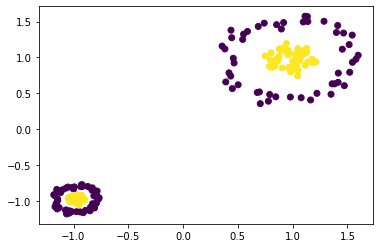

In [16]:
from sklearn.datasets import make_circles
from sklearn.preprocessing import StandardScaler

X1, y1 = make_circles(n_samples=100, noise=0.1, random_state=1, factor=0.25)
X2, y2 = make_circles(n_samples=100, noise=0.1, random_state=1, factor=0.25)
X2 = X2 * 3 + 10

X = np.row_stack([X1, X2])
y = np.row_stack([y1, y2]).flatten()

X = StandardScaler().fit_transform(X)

plt.scatter(X[:, 0], X[:, 1], c=y);

Параметр `n_neighbors` - указывает сколько соседей для каждой точки брать в рассмотрение. Чем он больше - тем глобальнее улавливаемое многообразие, то есть информация о мелких локальных "складках/сборках" теряется.

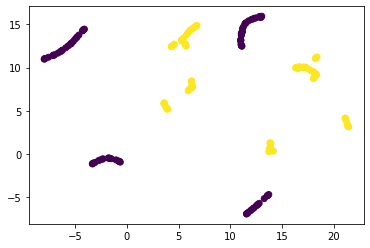

In [17]:
mapper = UMAP(n_components=2, n_neighbors=5).fit(X)
X_transformed = mapper.transform(X)
plt.scatter(X_transformed[:, 0], X_transformed[:, 1], c=y);

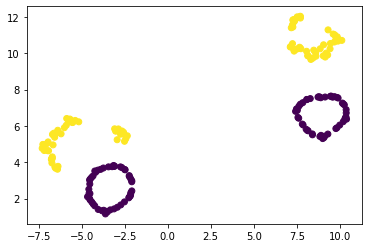

In [18]:
mapper = UMAP(n_components=2, n_neighbors=15).fit(X)
X_transformed = mapper.transform(X)
plt.scatter(X_transformed[:, 0], X_transformed[:, 1], c=y);

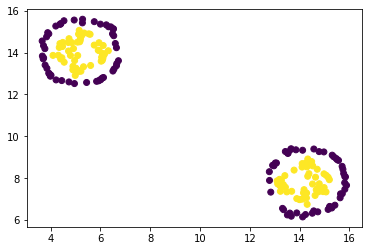

In [19]:
mapper = UMAP(n_components=2, n_neighbors=50).fit(X)
X_transformed = mapper.transform(X)
plt.scatter(X_transformed[:, 0], X_transformed[:, 1], c=y);

**UMAP** вполне подходит для задач:
1. Визуализации данных,
2. Инжиниринга признаков,
3. Препроцессинга табличных данных для кластеризации,
4. Препроцессинга векторов от нейросетей (для кластеризации или классификации).

Однако он может использоваться и в задачах обучения с учителем - то есть находить такие представления, которые хорошо разделяют классы.

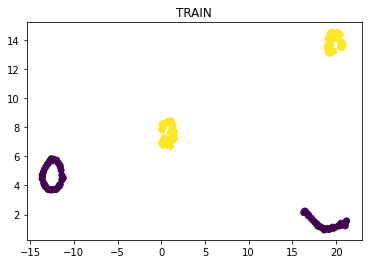

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=1, test_size=0.25
)

mapper = UMAP().fit(X_train, y_train)

X_transformed_train = mapper.transform(X_train)
plt.title('TRAIN')
plt.scatter(X_transformed_train[:, 0], X_transformed_train[:, 1], c=y_train);

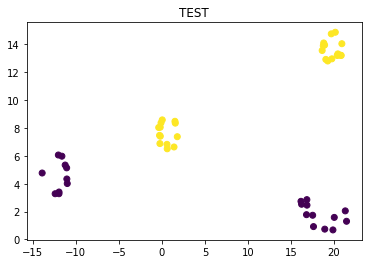

In [21]:
X_transformed_test = mapper.transform(X_test)
plt.title('TEST')
plt.scatter(X_transformed_test[:, 0], X_transformed_test[:, 1], c=y_test);